<a href="https://colab.research.google.com/github/JonhVGlez/Diplo_Modulo_VII/blob/main/PROYECTO_MODULO_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Definimos la Función y su Gradiente.

In [12]:
# --- 1. Definir la Funcion y su Gradiente ---

def f(X):
    """The non-convex function f(x, y). X is a numpy array [x, y]."""
    x, y = X[0], X[1]
    term1 = 0.02 * (x**2 + y**2)

    # Gaussian 1: centered at (-2, 1), angostos en x, planos en y
    term2_exp = -(((x + 2)**2 / 0.22) + ((y - 1)**2 / 3**2))
    term2 = -np.exp(term2_exp)

    # Gaussian 2: centered at (1, -1), planos en x, angostos en y
    term3_exp = -(((x - 1)**2 / 3**2) + ((y + 1)**2 / 0.3**2))
    term3 = -0.9 * np.exp(term3_exp)

    # Gaussian 3: centered at (2, 2)
    term4_exp = -(((x - 2)**2 / 0.5**2) + ((y - 2)**2 / 2**2))
    term4 = -0.7 * np.exp(term4_exp)

    return term1 + term2 + term3 + term4

def grad_f(X):
    """The gradient of the function f(x, y)."""
    x, y = X[0], X[1]

    # Partial derivative with respect to x (df/dx)
    df_dx = 0.04 * x

    # Contribution from Gaussian 1
    exp1 = np.exp(-(((x + 2)**2 / 0.22) + ((y - 1)**2 / 3**2)))
    df_dx += exp1 * (2 * (x + 2) / 0.2**2)

    # Contribution from Gaussian 2
    exp2 = np.exp(-(((x - 1)**2 / 3**2) + ((y + 1)**2 / 0.3**2)))
    df_dx += 0.9 * exp2 * (2 * (x - 1) / 3**2)

    # Contribution from Gaussian 3
    exp3 = np.exp(-(((x - 2)**2 / 0.5**2) + ((y - 2)**2 / 2**2)))
    df_dx += 0.7 * exp3 * (2 * (x - 2) / 0.5**2)

    # Partial derivative with respect to y (df/dy)
    df_dy = 0.04 * y

    # Contribution from Gaussian 1
    df_dy += exp1 * (2 * (y - 1) / 3**2)

    # Contribution from Gaussian 2
    df_dy += 0.9 * exp2 * (2 * (y + 1) / 0.3**2)

    # Contribution from Gaussian 3
    df_dy += 0.7 * exp3 * (2 * (y - 2) / 2**2)

    return np.array([df_dx, df_dy])


In [13]:
# --- 2. Optimization Algorithms ---

def run_optimizer(grad_func, initial_params, learning_rate, n_iterations, algo_name, **kwargs):
    """Generic function to run the optimization algorithms."""
    params = np.array(initial_params, dtype=float)
    history = [params.copy()]
    loss_history = [f(params)]

    # Initialize state for different optimizers
    if algo_name == 'SGD_Momentum':
        v = np.zeros_like(params)
        beta = kwargs.get('beta', 0.9)
    elif algo_name == 'AdaGrad':
        G = np.zeros_like(params)
        epsilon = kwargs.get('epsilon', 1e-8)
    elif algo_name == 'RMSProp':
        v = np.zeros_like(params)
        beta = kwargs.get('beta', 0.99)
        epsilon = kwargs.get('epsilon', 1e-8)
    elif algo_name == 'Adam':
        m = np.zeros_like(params)
        v = np.zeros_like(params)
        beta1 = kwargs.get('beta1', 0.9)
        beta2 = kwargs.get('beta2', 0.999)
        epsilon = kwargs.get('epsilon', 1e-8)
        t = 0 # timestep

    for _ in range(n_iterations):
        grad = grad_func(params)

        if algo_name == 'SGD':
            update = -learning_rate * grad

        elif algo_name == 'SGD_Momentum':
            v = beta * v + (1 - beta) * grad # Use (1-beta) * grad for SGD momentum style
            # For vanilla SGD, this is v = beta * v + grad and the update is -learning_rate * v,
            # but we use the first style to keep learning_rate meaning consistent.
            update = -learning_rate * v

        elif algo_name == 'AdaGrad':
            G += grad**2
            adjusted_lr = learning_rate / (np.sqrt(G) + epsilon)
            update = -adjusted_lr * grad

        elif algo_name == 'RMSProp':
            v = beta * v + (1 - beta) * grad**2
            adjusted_lr = learning_rate / (np.sqrt(v) + epsilon)
            update = -adjusted_lr * grad

        elif algo_name == 'Adam':
            t += 1
            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * grad**2

            # Bias correction
            m_hat = m / (1 - beta1**t)
            v_hat = v / (1 - beta2**t)

            adjusted_lr = learning_rate / (np.sqrt(v_hat) + epsilon)
            update = -adjusted_lr * m_hat

        params += update
        history.append(params.copy())
        loss_history.append(f(params))

    return np.array(history), np.array(loss_history)

In [14]:
# --- 3. Run Experiments and Plot ---
import numpy as np
import matplotlib.pyplot as plt
# Shared hyperparameters for all algorithms
LR = 0.01
ITERATIONS = 500

# Multiple initializations
initial_points = [
    [0.0, 0.0],   # Center
    [-4.0, 4.0],  # Top-left
    [4.0, -4.0]   # Bottom-right
]

algorithms = {
    'SGD': {'func': run_optimizer, 'kwargs': {'algo_name': 'SGD'}},
    'SGD_Momentum': {'func': run_optimizer, 'kwargs': {'algo_name': 'SGD_Momentum', 'beta': 0.9}},
    'AdaGrad': {'func': run_optimizer, 'kwargs': {'algo_name': 'AdaGrad'}},
    'RMSProp': {'func': run_optimizer, 'kwargs': {'algo_name': 'RMSProp', 'beta': 0.9}},
    'Adam': {'func': run_optimizer, 'kwargs': {'algo_name': 'Adam', 'beta1': 0.9, 'beta2': 0.999}}
}

results_nonconvex = {}

for name, algo in algorithms.items():
    all_trajectories = []
    all_losses = []

    for init_point in initial_points:
        trajectory, loss_hist = algo['func'](grad_f, init_point, LR, ITERATIONS, **algo['kwargs'])
        all_trajectories.append(trajectory)
        all_losses.append(loss_hist)

    results_nonconvex[name] = {
        'trajectories': all_trajectories,
        'losses': all_losses,
        'final_points': [t[-1] for t in all_trajectories],
        'final_losses': [l[-1] for l in all_losses]
    }


/tmp/ipython-input-2103810932.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(algorithms))


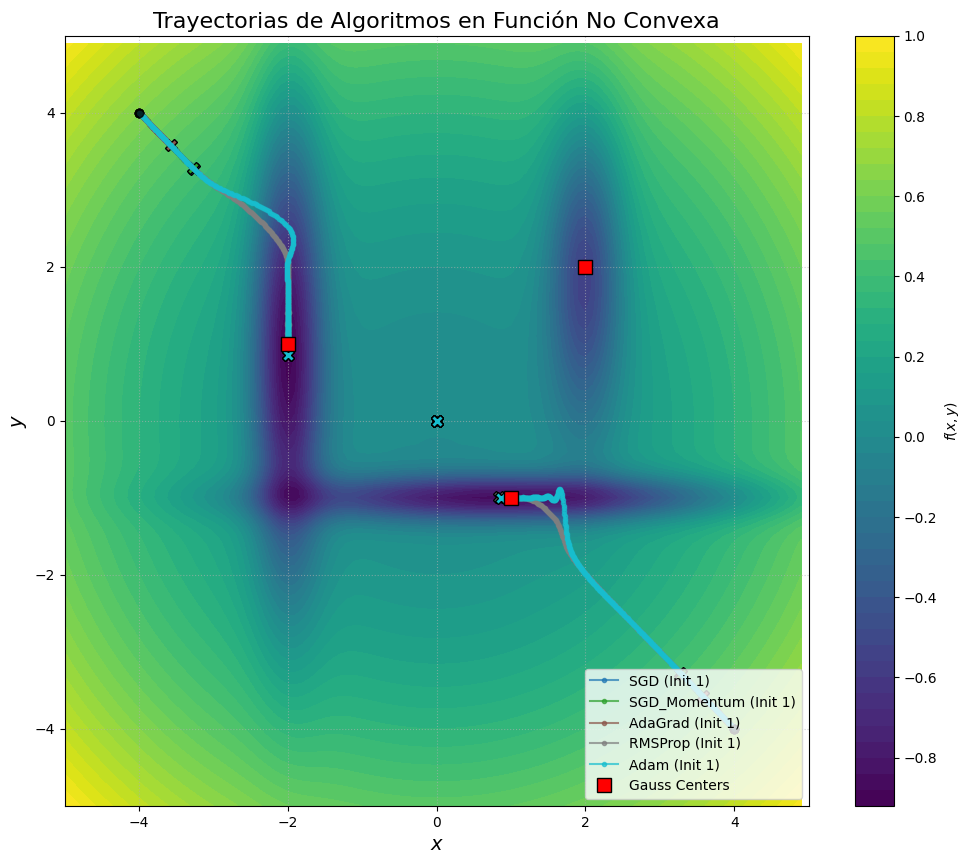

In [15]:
# --- Plotting ---
from matplotlib.colors import LogNorm
# 1. Trajectory Contour Plot
x_min, x_max = -5, 5
y_min, y_max = -5, 5
X_grid, Y_grid = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z_grid = f(np.array([X_grid, Y_grid]))

plt.figure(figsize=(12, 10))
# Contour plot of the function. Use LogNorm for better visualization of minima.
# Changed to linear scale as the function can produce negative values
contour = plt.contourf(X_grid, Y_grid, Z_grid, levels=50, cmap='viridis')
plt.colorbar(contour, label='$f(x, y)$')

# Plot trajectories
# Using a more distinct colormap and ensuring enough colors
colors = plt.cm.get_cmap('tab10', len(algorithms))
i = 0
for name, res in results_nonconvex.items():
    color = colors(i)
    for k, trajectory in enumerate(res['trajectories']):
        plt.plot(trajectory[:, 0], trajectory[:, 1], '.-', label=f'{name} (Init {k+1})' if k == 0 else '', alpha=0.7, color=color, linewidth=1.5)
        plt.plot(trajectory[0, 0], trajectory[0, 1], 'o', markersize=6, color='black', alpha=0.8) # Start
        plt.plot(trajectory[-1, 0], trajectory[-1, 1], 'X', markersize=8, color=color, markeredgecolor='black') # End
    i += 1

# Mark the approximate locations of the three Gaussian centers
plt.plot([-2, 1, 2], [1, -1, 2], 's', markersize=10, color='red', markeredgecolor='black', label='Gauss Centers')

plt.title('Trayectorias de Algoritmos en Función No Convexa', fontsize=16)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='lower right')
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

/tmp/ipython-input-2311477063.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('hsv', len(algorithms))


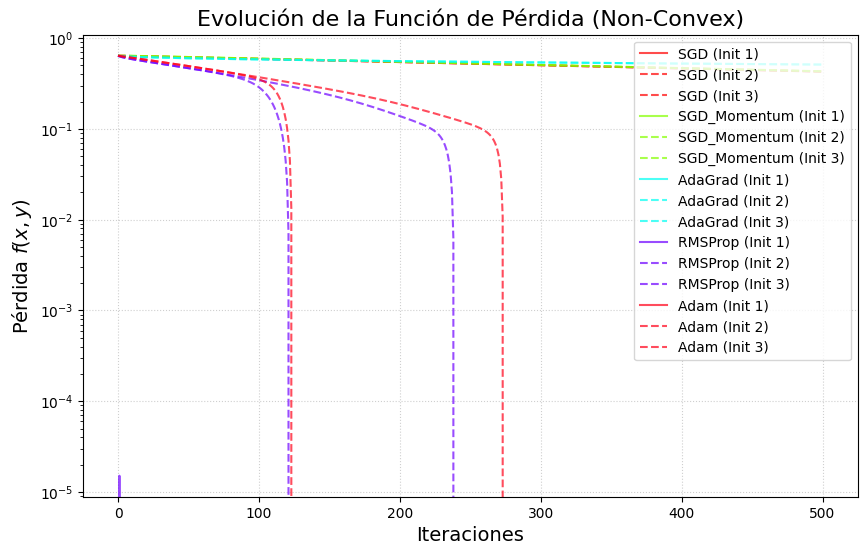

In [16]:
# 2. Loss Evolution Plot
plt.figure(figsize=(10, 6))
colors = plt.cm.get_cmap('hsv', len(algorithms))
i = 0
for name, res in results_nonconvex.items():
    color = colors(i)
    for k, loss_hist in enumerate(res['losses']):
        plt.plot(loss_hist, label=f'{name} (Init {k+1})', alpha=0.7, color=color, linestyle='-' if k==0 else '--')
    i += 1

plt.title('Evolución de la Función de Pérdida (Non-Convex)', fontsize=16)
plt.xlabel('Iteraciones', fontsize=14)
plt.ylabel('Pérdida $f(x, y)$', fontsize=14)
plt.yscale('log') # Use log scale for loss for better visualization
plt.legend(loc='upper right')
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

In [11]:
# 3. Analysis Summary
print("\n--- Análisis de Resultados (Función No Convexa) ---")
print("Algoritmo | Inicialización | Punto Final (x, y) | Pérdida Final")
print("----------|------------------|---------------------|-----------------")
for name, res in results_nonconvex.items():
    for k in range(len(initial_points)):
        print(f"{name:<9} | Init {k+1:<10} | ({res['final_points'][k][0]:.4f}, {res['final_points'][k][1]:.4f}) | {res['final_losses'][k]:.6f}")


--- Análisis de Resultados (Función No Convexa) ---
Algoritmo | Inicialización | Punto Final (x, y) | Pérdida Final
----------|------------------|---------------------|-----------------
SGD       | Init 1          | (0.0000, -0.0012) | -0.000012
SGD       | Init 2          | (-3.2604, 3.2747) | 0.426662
SGD       | Init 3          | (3.2748, -3.2748) | 0.428969
SGD_Momentum | Init 1          | (0.0000, -0.0012) | -0.000012
SGD_Momentum | Init 2          | (-3.2735, 3.2843) | 0.429688
SGD_Momentum | Init 3          | (3.2843, -3.2843) | 0.431473
AdaGrad   | Init 1          | (0.0001, -0.0079) | -0.000013
AdaGrad   | Init 2          | (-3.5755, 3.5757) | 0.511394
AdaGrad   | Init 3          | (3.5757, -3.5757) | 0.511422
RMSProp   | Init 1          | (0.0051, -0.0030) | -0.000012
RMSProp   | Init 2          | (-1.9934, 0.8521) | -0.903381
RMSProp   | Init 3          | (0.8419, -0.9930) | -0.863464
Adam      | Init 1          | (0.0001, -0.0079) | -0.000013
Adam      | Init 2          | 

In [17]:
# --- 1. Generate Heavy-Tailed Data ---
np.random.seed(42)
N_data = 10000
# X ~ Pareto distribution (heavy-tailed)
X = 5 * (1 + np.random.pareto(a=1.5, size=N_data))
# Y = X + Gaussian noise
Y = X + np.random.normal(loc=0, scale=16, size=N_data)

# Reshape X and Y for a simple linear regression model (Y = theta0 + theta1 * X)
X_b = np.vstack([np.ones(N_data), X]).T # Add bias term (column of 1s)


In [18]:
# --- 2. Define Loss and Gradient for Linear Regression (MSE) ---

def mse_loss(X_b, Y, Theta):
    """Mean Squared Error loss for linear regression."""
    M = len(Y)
    predictions = X_b.dot(Theta)
    return np.sum((predictions - Y)**2) / (2 * M)

def mse_grad(X_b, Y, Theta):
    """Gradient of the MSE loss."""
    M = len(Y)
    predictions = X_b.dot(Theta)
    # Gradient = (1/M) * X_b.T * (predictions - Y)
    return X_b.T.dot(predictions - Y) / M


In [19]:
# --- 3. Optimization Algorithms for Linear Regression ---

def run_regression_optimizer(X_b, Y, initial_theta, learning_rate, n_epochs, batch_size, algo_name, **kwargs):
    """Runs an optimizer on the linear regression problem using mini-batch SGD."""
    Theta = np.array(initial_theta, dtype=float)
    loss_history = [mse_loss(X_b, Y, Theta)]
    N_data = len(Y)

    # Initialize state for different optimizers
    if algo_name == 'SGD_Momentum':
        v = np.zeros_like(Theta)
        beta = kwargs.get('beta', 0.9)
    elif algo_name == 'AdaGrad':
        G = np.zeros_like(Theta)
        epsilon = kwargs.get('epsilon', 1e-8)
    elif algo_name == 'RMSProp':
        v = np.zeros_like(Theta)
        beta = kwargs.get('beta', 0.99)
        epsilon = kwargs.get('epsilon', 1e-8)
    elif algo_name == 'Adam':
        m = np.zeros_like(Theta)
        v = np.zeros_like(Theta)
        beta1 = kwargs.get('beta1', 0.9)
        beta2 = kwargs.get('beta2', 0.999)
        epsilon = kwargs.get('epsilon', 1e-8)
        t = 0

    for epoch in range(n_epochs):
        # Shuffle data indices for mini-batch
        indices = np.arange(N_data)
        np.random.shuffle(indices)

        for start_idx in range(0, N_data, batch_size):
            end_idx = start_idx + batch_size
            batch_indices = indices[start_idx:end_idx]
            X_batch, Y_batch = X_b[batch_indices], Y[batch_indices]

            grad = mse_grad(X_batch, Y_batch, Theta)

            # Update rules (identical to non-convex case, but applied to Theta)
            if algo_name == 'SGD':
                update = -learning_rate * grad

            elif algo_name == 'SGD_Momentum':
                v = beta * v + (1 - beta) * grad
                update = -learning_rate * v

            elif algo_name == 'AdaGrad':
                G += grad**2
                adjusted_lr = learning_rate / (np.sqrt(G) + epsilon)
                update = -adjusted_lr * grad

            elif algo_name == 'RMSProp':
                v = beta * v + (1 - beta) * grad**2
                adjusted_lr = learning_rate / (np.sqrt(v) + epsilon)
                update = -adjusted_lr * grad

            elif algo_name == 'Adam':
                t += 1
                m = beta1 * m + (1 - beta1) * grad
                v = beta2 * v + (1 - beta2) * grad**2
                m_hat = m / (1 - beta1**t)
                v_hat = v / (1 - beta2**t)
                adjusted_lr = learning_rate / (np.sqrt(v_hat) + epsilon)
                update = -adjusted_lr * m_hat

            Theta += update
            loss_history.append(mse_loss(X_b, Y, Theta))

    return Theta, np.array(loss_history)


/tmp/ipython-input-2269185814.py:7: RuntimeWarning: overflow encountered in square
  return np.sum((predictions - Y)**2) / (2 * M)
/tmp/ipython-input-196124253.py:67: RuntimeWarning: invalid value encountered in add
  Theta += update
/tmp/ipython-input-196124253.py:45: RuntimeWarning: invalid value encountered in add
  v = beta * v + (1 - beta) * grad
/tmp/ipython-input-3133933752.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('hsv', len(algorithms_reg))


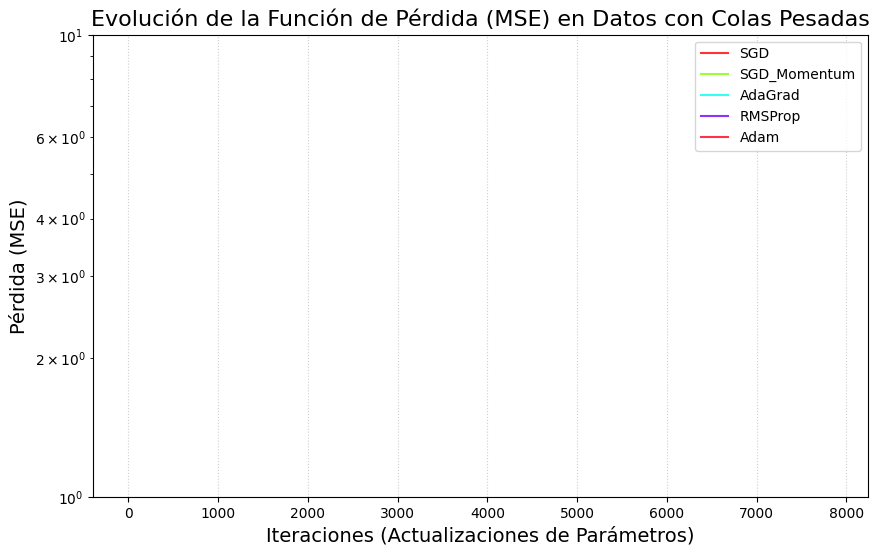

In [21]:
# --- 4. Run Experiments and Plot ---

# Parameters
LR_reg = 0.01
N_EPOCHS = 50
BATCH_SIZE = 64
initial_theta = [0.0, 0.0] # [theta0, theta1]

algorithms_reg = {
    'SGD': {'func': run_regression_optimizer, 'kwargs': {'algo_name': 'SGD'}},
    'SGD_Momentum': {'func': run_regression_optimizer, 'kwargs': {'algo_name': 'SGD_Momentum', 'beta': 0.9}},
    'AdaGrad': {'func': run_regression_optimizer, 'kwargs': {'algo_name': 'AdaGrad'}},
    'RMSProp': {'func': run_regression_optimizer, 'kwargs': {'algo_name': 'RMSProp', 'beta': 0.9}},
    'Adam': {'func': run_regression_optimizer, 'kwargs': {'algo_name': 'Adam', 'beta1': 0.9, 'beta2': 0.999}}
}

results_heavy_tail = {}
for name, algo in algorithms_reg.items():
    final_theta, loss_hist = algo['func'](X_b, Y, initial_theta, LR_reg, N_EPOCHS, BATCH_SIZE, **algo['kwargs'])
    results_heavy_tail[name] = {'final_theta': final_theta, 'losses': loss_hist}

# Loss Evolution Plot
plt.figure(figsize=(10, 6))
colors = plt.cm.get_cmap('hsv', len(algorithms_reg))
i = 0
for name, res in results_heavy_tail.items():
    plt.plot(res['losses'], label=name, alpha=0.8, color=colors(i))
    i += 1

plt.title('Evolución de la Función de Pérdida (MSE) en Datos con Colas Pesadas', fontsize=16)
plt.xlabel('Iteraciones (Actualizaciones de Parámetros)', fontsize=14)
plt.ylabel('Pérdida (MSE)', fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right')
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()


In [22]:
# Analysis Summary
print("\n--- Análisis de Resultados (Colas Pesadas) ---")
print("Algoritmo | Theta0 (Intercepto) | Theta1 (Pendiente) | Pérdida Final")
print("----------|---------------------|--------------------|-----------------")
for name, res in results_heavy_tail.items():
    T0, T1 = res['final_theta']
    L = res['losses'][-1]
    print(f"{name:<9} | {T0:.4f} | {T1:.4f} | {L:.6f}")


--- Análisis de Resultados (Colas Pesadas) ---
Algoritmo | Theta0 (Intercepto) | Theta1 (Pendiente) | Pérdida Final
----------|---------------------|--------------------|-----------------
SGD       | nan | nan | nan
SGD_Momentum | nan | nan | nan
AdaGrad   | 1.3342 | 0.6500 | 190.370936
RMSProp   | 0.1102 | 0.9773 | 128.307772
Adam      | 0.1438 | 1.0036 | 127.924373
